In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mstats, chisquare
from datetime import datetime
import timedelta
from matplotlib import pylab as plt
import seaborn as sns
sns.set()
sns.set_style('white')

# **Read-in data**

In [2]:
DIRECTORY = "/data/elastic-notebook/data/ecommerce-behavior-data-from-multi-category-store/"
data_oct = pd.read_csv(DIRECTORY+"2019-Oct.csv")
data_oct.shape

(42448764, 9)

In [3]:
data_nov = pd.read_csv(DIRECTORY+"2019-Nov.csv")
data_nov.shape

(67501979, 9)

# **Preprocess and summarise data**

In [5]:
data_oct_smrtph = data_oct[data_oct.category_code == 'electronics.smartphone']
data_nov_smrtph = data_nov[data_nov.category_code == 'electronics.smartphone']
data = pd.concat([data_oct_smrtph, data_nov_smrtph], ignore_index=True)
# data_test = data.loc[:5000, :]
data_test = data_oct_smrtph.copy().iloc[::100, :]
data_test.describe(include='all')

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,115073,115073,1.150730e+05,1.150730e+05,115073,114846,115073.000000,1.150730e+05,115073
unique,115073,3,NaN,NaN,1,38,NaN,NaN,110325
top,2019-10-01 00:00:04 UTC,view,NaN,NaN,electronics.smartphone,samsung,NaN,NaN,af47ca99-d9dc-44f2-86fe-b6160be82686
freq,1,106261,NaN,NaN,115073,37929,NaN,NaN,6
mean,NaN,NaN,1.004553e+06,2.053014e+18,NaN,NaN,471.546460,5.359025e+08,NaN
std,NaN,NaN,7.183682e+02,2.560011e+02,NaN,NaN,402.032529,1.895174e+07,NaN
min,NaN,NaN,1.000978e+06,2.053014e+18,NaN,NaN,0.000000,3.492939e+08,NaN
25%,NaN,NaN,1.004259e+06,2.053014e+18,NaN,NaN,179.260000,5.167002e+08,NaN
50%,NaN,NaN,1.004833e+06,2.053014e+18,NaN,NaN,283.230000,5.354896e+08,NaN
75%,NaN,NaN,1.005018e+06,2.053014e+18,NaN,NaN,720.670000,5.550156e+08,NaN


In [6]:
data_test = data_test.astype(
    {
    'product_id': 'str', 
    'category_id': 'str',
    'user_id': 'str'
    })
len_pid = data_test.product_id.str.len().max()
len_cid = data_test.category_id.str.len().max()
len_uid = data_test.user_id.str.len().max()
data_test['product_id'] = data_test.product_id.apply(lambda x: x.zfill(len_pid))
data_test['category_id'] = data_test.category_id.apply(lambda x: x.zfill(len_cid))
data_test['user_id'] = data_test.user_id.apply(lambda x: x.zfill(len_uid))
data_test.describe(include='all')

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,115073,115073,115073,115073,115073,114846,115073.000000,115073,115073
unique,115073,3,1075,1,1,38,NaN,96656,110325
top,2019-10-01 00:00:04 UTC,view,1004856,2053013555631882655,electronics.smartphone,samsung,NaN,512365995,af47ca99-d9dc-44f2-86fe-b6160be82686
freq,1,106261,5036,115073,115073,37929,NaN,32,6
mean,NaN,NaN,NaN,NaN,NaN,NaN,471.546460,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,402.032529,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,179.260000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,283.230000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,720.670000,NaN,NaN


In [7]:
data.isna().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code        0
brand            43328
price                0
user_id              0
user_session         4
dtype: int64

In [8]:
data_test.dropna(inplace=True)
data_test.shape


(114846, 9)

In [9]:
# num of item by brand
item_by_brand = data_test.groupby("brand")["product_id"].count()\
    .to_frame().sort_values(by='product_id', ascending=False)
    
item_by_brand.head(10)

,product_id
brand,
samsung,37929
apple,32681
xiaomi,21804
huawei,10140
oppo,4837
meizu,1549
vivo,1090
honor,764
oneplus,683


In [10]:
# num of unique user and session
print(
    f"Unique user: {data_test.user_id.nunique()}",
    f"Unique session: {data_test.user_session.nunique()}",
    sep='\n'
    )

Unique user: 96510
Unique session: 110122


In [11]:
# transform date column
data_test.reset_index(inplace=True)
data_test['date'] = data_test.event_time.astype(np.datetime64).apply(lambda t: t.date())
data_test['time'] = data_test.event_time.astype(np.datetime64).apply(lambda t: t.time())
data_test.time.head()

0    00:00:04
1    00:05:48
2    00:12:51
3    00:52:19
4    02:18:10
Name: time, dtype: object

In [12]:
# assign weekday to date
data_test['weekday'] = data_test.date.apply(lambda dt: dt.strftime("%A"))
data_test[['date', 'weekday']].head()

,date,weekday
0,2019-10-01,Tuesday
1,2019-10-01,Tuesday
2,2019-10-01,Tuesday
3,2019-10-01,Tuesday
4,2019-10-01,Tuesday


In [13]:
# assign session label to time
# session_labels = ['0-6', '6-12', '12-18', '18-24']
# time_session_break = [0, 6, 12, 18, np.Inf]
session_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
time_session_break = [0, 3, 6, 9, 12, 15, 18, 21, np.Inf]
data_test['hour'] = data_test.time.apply(lambda t: t.hour)
data_test['time_session'] = pd.cut(
    data_test.hour,
    bins=time_session_break,
    labels=session_labels,
    right=False
    )
data_test[['time', 'time_session']].tail()


,time,time_session
114841,23:43:42,21-24
114842,23:47:46,21-24
114843,23:51:40,21-24
114844,23:54:51,21-24
114845,23:59:10,21-24


# **Data mining**

## **1. Time distribution analysis**

### Daily distribution of number of events, by hour

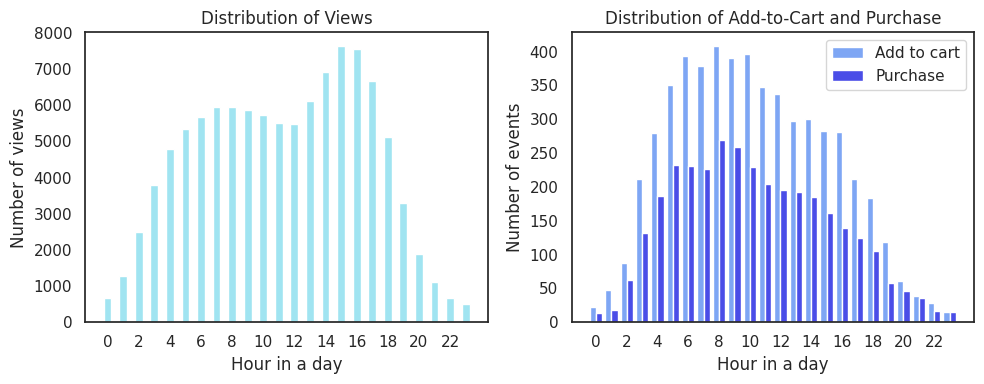

In [14]:
# num of events by hour
view_by_hour = data_test[data_test.event_type=='view'].groupby("hour")["event_type"].count()\
    .to_frame().rename(columns={'event_type': 'view'})
cart_by_hour = data_test[data_test.event_type=='cart'].groupby("hour")["event_type"].count()\
    .to_frame().rename(columns={'event_type': 'cart'})
purchase_by_hour = data_test[data_test.event_type=='purchase'].groupby("hour")["event_type"].count()\
    .to_frame().rename(columns={'event_type': 'purchase'})
event_by_hour = view_by_hour.merge(cart_by_hour, on='hour', how='left')\
    .merge(purchase_by_hour,on='hour', how='left').fillna(0)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
ind = np.arange(event_by_hour.index.min(), event_by_hour.index.max()+1)
width = 0.5
view_bar = ax1.bar(ind, event_by_hour.view, width=width, color='#A0E4F1')
ax1.set_xticks(ind)
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_xlabel("Hour in a day")
ax1.set_ylabel("Number of views")
ax1.set_title("Distribution of Views")

width = 0.4
cart_bar = ax2.bar(ind, event_by_hour.cart, width=width, color='#7EA6F4')
purchase_bar = ax2.bar(ind+width, event_by_hour.purchase, width=width, color='#4A4DE7')
ax2.set_xticks(ind+width/2)
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_xticklabels(ind[::2])
ax2.set_xlabel("Hour in a day")
ax2.set_ylabel("Number of events")
ax2.set_title("Distribution of Add-to-Cart and Purchase")
ax2.legend((cart_bar, purchase_bar), ('Add to cart', 'Purchase'))
fig.tight_layout()


### Daily distribution of number of events, by time session

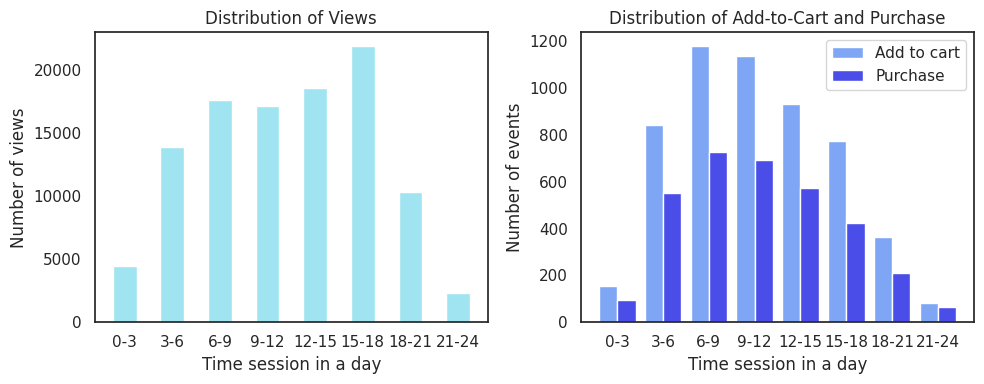

In [15]:
# num of events by session
view_by_time_session = data_test[data_test.event_type=='view'].groupby("time_session")["event_type"].count()\
    .to_frame().rename(columns={'event_type': 'view'})
cart_by_time_session = data_test[data_test.event_type=='cart'].groupby("time_session")["event_type"].count()\
    .to_frame().rename(columns={'event_type': 'cart'})
purchase_by_time_session = data_test[data_test.event_type=='purchase'].groupby("time_session")["event_type"].count()\
    .to_frame().rename(columns={'event_type': 'purchase'})
event_by_time_session = view_by_time_session.merge(cart_by_time_session, on='time_session', how='left')\
    .merge(purchase_by_time_session, on='time_session', how='left').fillna(0)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ind = np.arange(event_by_time_session.index.nunique())
width = 0.5
ax1.bar(ind, event_by_time_session.view, width=width, color='#A0E4F1')
ax1.set_xticks(ind)
ax1.set_xticklabels(session_labels)
ax1.set_xlabel("Time session in a day")
ax1.set_ylabel("Number of views")
ax1.set_title("Distribution of Views")

width = 0.4
cart_bar = ax2.bar(ind, event_by_time_session.cart, width=width, color='#7EA6F4')
purchase_bar = ax2.bar(ind+width, event_by_time_session.purchase, width=width, color='#4A4DE7')
ax2.set_xticks(ind+width/2)
ax2.set_xticklabels(session_labels)
ax2.set_xlabel("Time session in a day")
ax2.set_ylabel("Number of events")
ax2.set_title("Distribution of Add-to-Cart and Purchase")
ax2.legend((cart_bar, purchase_bar), ('Add to cart', 'Purchase'))
fig.tight_layout()

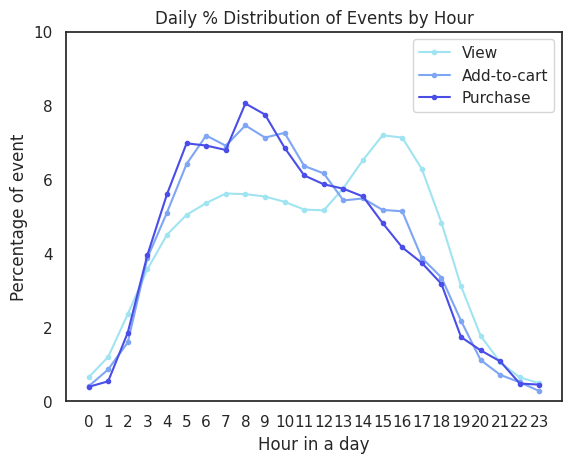

In [16]:
# combination showing ratio
event_by_hour['view_pct'] = event_by_hour.view / sum(event_by_hour.view) * 100
event_by_hour['cart_pct'] = event_by_hour.cart/ sum(event_by_hour.cart) * 100
event_by_hour['purchase_pct'] = event_by_hour.purchase / sum(event_by_hour.purchase) * 100

hours = np.arange(0, 24)
view_pct_hr = plt.plot(event_by_hour.index, event_by_hour.view_pct, marker='.', color='#A0E4F1', label='View')
cart_pct_hr = plt.plot(event_by_hour.index, event_by_hour.cart_pct, marker='.', color='#7EA6F4', label='Add-to-cart')
purchase_pct_hr = plt.plot(event_by_hour.index, event_by_hour.purchase_pct, marker='.', color='#4A4DE7', label='Purchase')
plt.xticks(hours)
plt.ylim([0, 10])
plt.xlabel("Hour in a day")
plt.ylabel("Percentage of event")
plt.title("Daily % Distribution of Events by Hour")
plt.legend()

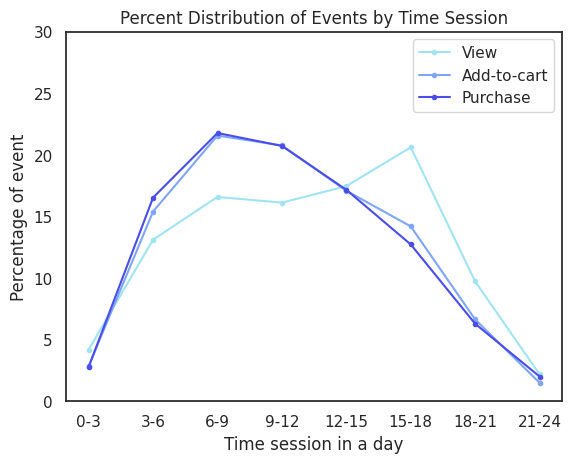

In [17]:
# combination showing ratio
event_by_time_session['view_pct'] = event_by_time_session.view / sum(event_by_time_session.view) * 100
event_by_time_session['cart_pct'] = event_by_time_session.cart/ sum(event_by_time_session.cart) * 100
event_by_time_session['purchase_pct'] = event_by_time_session.purchase / sum(event_by_time_session.purchase) * 100

time_sessions = np.arange(0, len(session_labels))
view_pct_ss = plt.plot(event_by_time_session.index, event_by_time_session.view_pct, marker='.', color='#A0E4F1', label='View')
cart_pct_ss = plt.plot(event_by_time_session.index, event_by_time_session.cart_pct, marker='.', color='#7EA6F4', label='Add-to-cart')
purchase_pct_ss = plt.plot(event_by_time_session.index, event_by_time_session.purchase_pct, marker='.', color='#4A4DE7', label='Purchase')
plt.xticks(time_sessions, session_labels)
plt.ylim([0, 30])
plt.xlabel("Time session in a day")
plt.ylabel("Percentage of event")
plt.title("Percent Distribution of Events by Time Session")
plt.legend()


### Daily distribution of events, facet by weekday

In [18]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dict = dict(zip(weekdays, list(range(1,8))))
data_test['nth_day_of_week'] = data_test.weekday.map(weekday_dict)

# view
view_by_ss_wkdy = data_test[data_test.event_type == 'view'].groupby(['weekday', 'time_session'])['event_type'].count()\
    .to_frame().rename(columns={'event_type': 'num_view'}).reset_index()
view_by_ss_wkdy['weekday'] = pd.Categorical(view_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
view_by_ss_wkdy['time_session'] = pd.Categorical(view_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
view_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)
# view_by_ss_wkdy.head(8)

# cart
cart_by_ss_wkdy = data_test[data_test.event_type == 'cart'].groupby(['weekday', 'time_session'])['event_type'].count()\
    .to_frame().rename(columns={'event_type': 'num_cart'}).reset_index()
cart_by_ss_wkdy['weekday'] = pd.Categorical(cart_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
cart_by_ss_wkdy['time_session'] = pd.Categorical(cart_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
cart_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)

# purchase
purchase_by_ss_wkdy = data_test[data_test.event_type == 'purchase'].groupby(['weekday', 'time_session'])['event_type'].count()\
    .to_frame().rename(columns={'event_type': 'num_purchase'}).reset_index()
purchase_by_ss_wkdy['weekday'] = pd.Categorical(purchase_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
purchase_by_ss_wkdy['time_session'] = pd.Categorical(purchase_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
purchase_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)
purchase_by_ss_wkdy.head(8)

,weekday,time_session,num_purchase
8,Monday,0-3,9
9,Monday,3-6,77
10,Monday,6-9,107
11,Monday,9-12,94
12,Monday,12-15,82
13,Monday,15-18,51
14,Monday,18-21,27
15,Monday,21-24,6


In [19]:
# events per weekday
view_per_wkdy = view_by_ss_wkdy.groupby("weekday")['num_view'].sum().to_frame()
cart_per_wkdy = cart_by_ss_wkdy.groupby("weekday")['num_cart'].sum().to_frame()
purchase_per_wkdy = purchase_by_ss_wkdy.groupby("weekday")['num_purchase'].sum().to_frame()
event_by_weekday = pd.concat([view_per_wkdy, cart_per_wkdy, purchase_per_wkdy], axis=1)
event_by_weekday

,num_view,num_cart,num_purchase
weekday,,,
Monday,13461,721,453
Tuesday,16729,822,503
Wednesday,16641,801,526
Thursday,16381,815,539
Friday,14295,842,458
Saturday,13998,736,407
Sunday,14535,730,453


Text(0.5, 1.0, 'Weekly Distribution of Events')

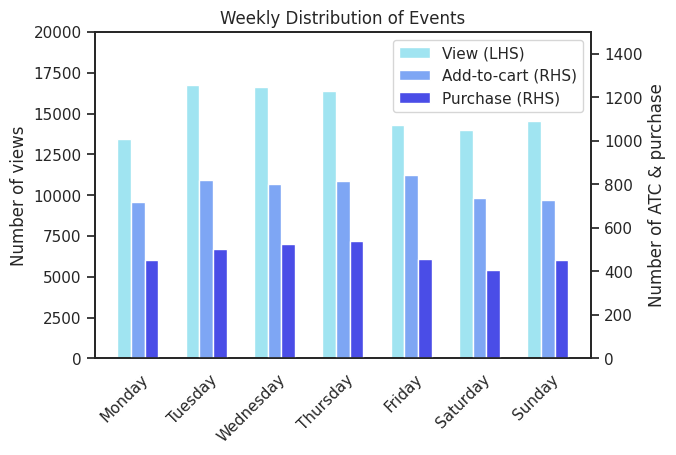

In [20]:
# plot events per weekday
fig, ax1 = plt.subplots()

width = 0.2
xticks = np.arange(0, len(weekdays))

view_wkdy_plot = ax1.bar(xticks, event_by_weekday.num_view, width=width, color='#A0E4F1')
ax1.set_ylim([0, 20000])
ax1.set_ylabel("Number of views")

ax2 = ax1.twinx()
cart_wkdy_plot = ax2.bar(xticks+width, event_by_weekday.num_cart, width=width, color='#7EA6F4')
purchase_wkdy_plot = ax2.bar(xticks+width*2, event_by_weekday.num_purchase, width=width, color='#4A4DE7')
ax2.set_ylim([0, 1500])
ax2.set_ylabel("Number of ATC & purchase")

plt.legend((view_wkdy_plot, cart_wkdy_plot, purchase_wkdy_plot), ('View (LHS)', 'Add-to-cart (RHS)', 'Purchase (RHS)'))
plt.xticks(xticks+width*2, weekdays)
fig.autofmt_xdate(rotation=45)
plt.title('Weekly Distribution of Events')

array([[<AxesSubplot: title={'center': 'Monday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Tuesday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Wednesday'}, xlabel='Time session'>],
       [<AxesSubplot: title={'center': 'Thursday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Friday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Saturday'}, xlabel='Time session'>],
       [<AxesSubplot: title={'center': 'Sunday'}, xlabel='Time session'>,
        <AxesSubplot: xlabel='Time session'>,
        <AxesSubplot: xlabel='Time session'>]], dtype=object)

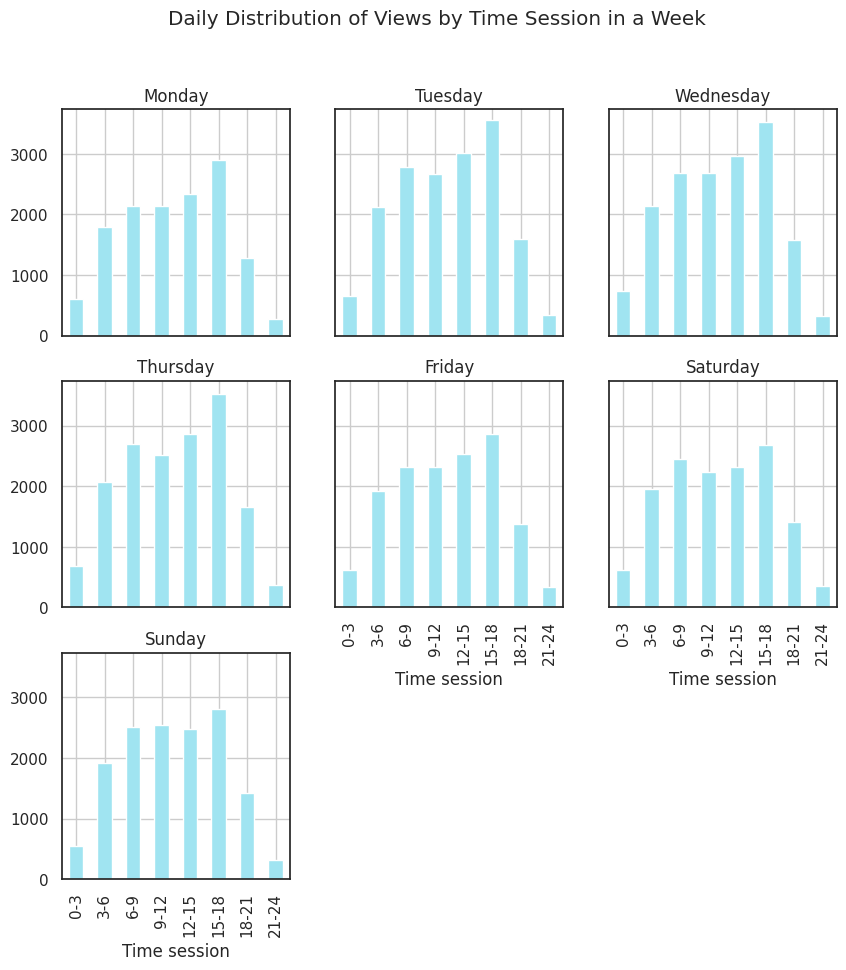

In [21]:
# Daily split
view_by_ss_wkdy_pvt = view_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_view')
view_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True, 
    layout=(3,3), 
    figsize=(10, 10), 
    color='#A0E4F1',
    sharex=True, 
    sharey=True, 
    legend=False, 
    xlabel='Time session',
    title='Daily Distribution of Views by Time Session in a Week',
    grid=True)

array([[<AxesSubplot: title={'center': 'Monday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Tuesday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Wednesday'}, xlabel='Time session'>],
       [<AxesSubplot: title={'center': 'Thursday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Friday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Saturday'}, xlabel='Time session'>],
       [<AxesSubplot: title={'center': 'Sunday'}, xlabel='Time session'>,
        <AxesSubplot: xlabel='Time session'>,
        <AxesSubplot: xlabel='Time session'>]], dtype=object)

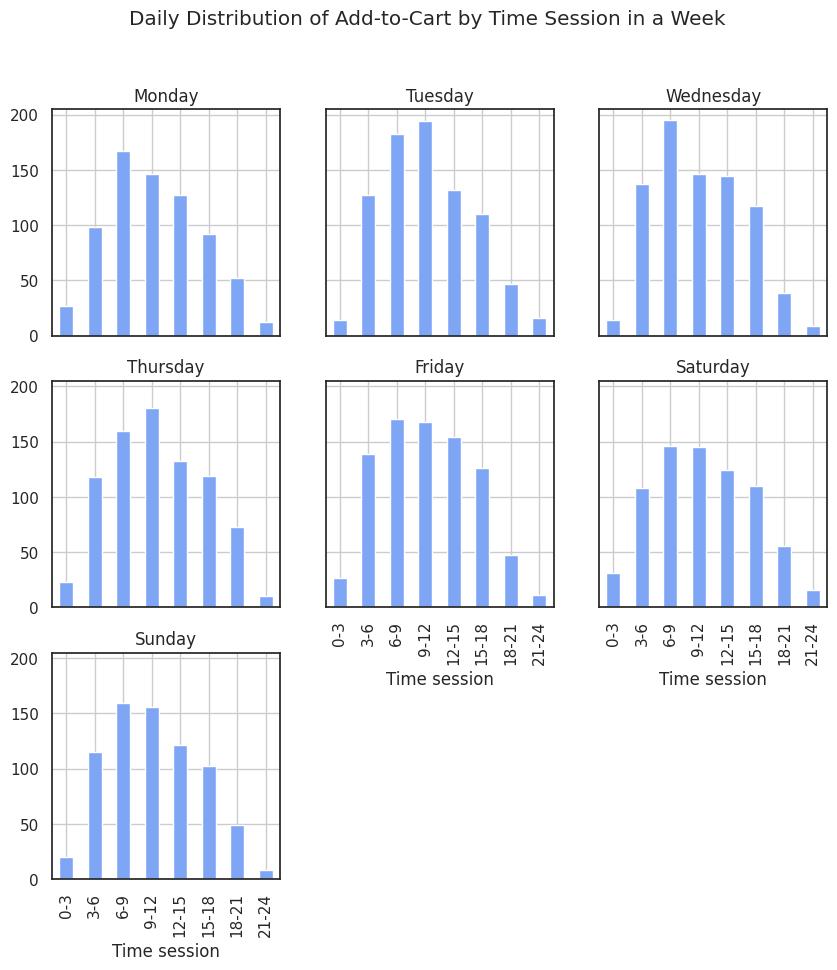

In [22]:
# Daily split
cart_by_ss_wkdy_pvt = cart_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_cart')
cart_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True, 
    layout=(3,3), 
    figsize=(10, 10), 
    color='#7EA6F4',
    sharex=True, 
    sharey=True, 
    legend=False, 
    xlabel='Time session',
    title='Daily Distribution of Add-to-Cart by Time Session in a Week',
    grid=True)

array([[<AxesSubplot: title={'center': 'Monday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Tuesday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Wednesday'}, xlabel='Time session'>],
       [<AxesSubplot: title={'center': 'Thursday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Friday'}, xlabel='Time session'>,
        <AxesSubplot: title={'center': 'Saturday'}, xlabel='Time session'>],
       [<AxesSubplot: title={'center': 'Sunday'}, xlabel='Time session'>,
        <AxesSubplot: xlabel='Time session'>,
        <AxesSubplot: xlabel='Time session'>]], dtype=object)

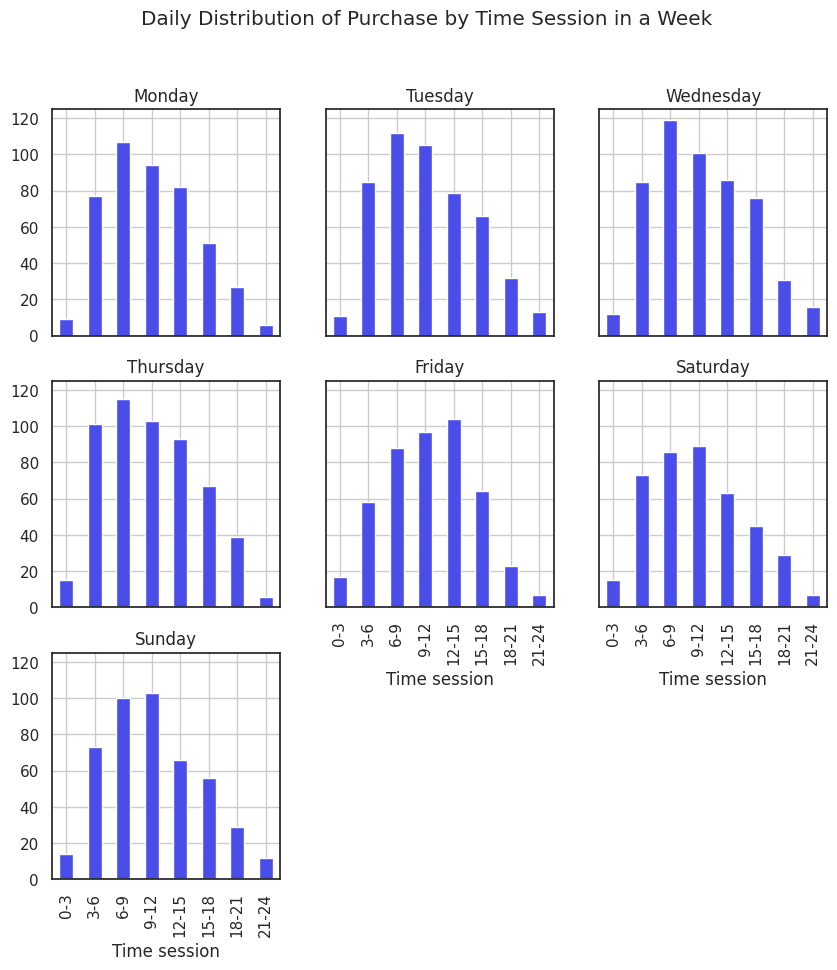

In [23]:
# Daily split
purchase_by_ss_wkdy_pvt = purchase_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_purchase')
purchase_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True, 
    layout=(3,3), 
    figsize=(10, 10), 
    color='#4A4DE7',
    sharex=True, 
    sharey=True, 
    legend=False, 
    xlabel='Time session',
    title='Daily Distribution of Purchase by Time Session in a Week',
    grid=True)

### Hypo testing with Chi-square test
H0 - shoppers have the time tendency for different events in a day

In [24]:
def chi2_test(obs, exp, main_cat: int = 0, alpha = 0.05):
    from scipy.stats import chisquare

    chi, pval = chisquare(f_obs=obs, f_exp=exp)
    if pval < alpha:
        print(f"Statistically significant under level of sig={alpha} ({pval}). H0 rejected.")
    else:
        print(f"NOT statistically significant under level of sig={alpha} ({pval}). H0 not rejected.")
    
    return chi, pval



In [25]:
data_test['half_of_day'] = data_test.hour.apply(lambda x: 2 if x > 12 else 1)
data_test['event_retype'] = data_test.event_type.apply(lambda x: 2 if x in ['cart', 'purchase'] else 1)

In [26]:
chi_crosstab = pd.crosstab(data_test.half_of_day, data_test.event_retype, margins=True)
chi_crosstab

event_retype,1,2,All
half_of_day,,,
1,58520,5909,64429
2,47520,2897,50417
All,106040,8806,114846


In [27]:
obs = chi_crosstab.iloc[0, :]
exp = chi_crosstab.iloc[1, :]
pval, chi = chi2_test(obs, exp)

Statistically significant under level of sig=0.05 (0.0). H0 rejected.


H0 - shoppers have the same time tendency for different events in a week

In [28]:
chi_ctab_wk = pd.crosstab(data_test.weekday, data_test.event_retype, margins=True)
chi_ctab_wk

event_retype,1,2,All
weekday,,,
Friday,14295,1300,15595
Monday,13461,1174,14635
Saturday,13998,1143,15141
Sunday,14535,1183,15718
Thursday,16381,1354,17735
Tuesday,16729,1325,18054
Wednesday,16641,1327,17968
All,106040,8806,114846


In [29]:
pval, chi = chi2_test(chi_ctab_wk.iloc[:-1, 0], chi_ctab_wk.iloc[:-1, 1])

Statistically significant under level of sig=0.05 (0.0). H0 rejected.


**Conclusion: shoppers have different time preference for viewing vs. ATC & check-outs when shopping on e-comm platform.**

## **2. Funnel analysis**

### Add-to-cart rate (ATCR) and cart abandonment rate

In [30]:
user_session_by_time_session = data_test.drop_duplicates(subset=['user_session']).groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session"})
user_session_by_time_session.head()

,num_user_session
time_session,
0-3,4548
3-6,14762
6-9,18746
9-12,18223
12-15,19241


In [31]:
cart_sessions = data_test[data_test.event_type == 'cart']
user_session_cart_by_time_session = cart_sessions.groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session_cart"})
user_session_cart_by_time_session.head()

,num_user_session_cart
time_session,
0-3,156
3-6,842
6-9,1179
9-12,1135
12-15,934


In [32]:
atcr_by_time_session = pd.concat([user_session_by_time_session, user_session_cart_by_time_session], axis=1)
atcr_by_time_session['atcr'] = atcr_by_time_session.num_user_session_cart / atcr_by_time_session.num_user_session * 100
atcr_by_time_session.head()

,num_user_session,num_user_session_cart,atcr
time_session,,,
0-3,4548,156,3.430079
3-6,14762,842,5.703834
6-9,18746,1179,6.289342
9-12,18223,1135,6.228393
12-15,19241,934,4.854218


In [33]:
# cart-to-checkout rate
purchase_sessions = data_test[data_test.event_type == 'purchase']
user_session_purchase_by_time_session = purchase_sessions.groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session_purchase"})
user_session_purchase_by_time_session.head()

,num_user_session_purchase
time_session,
0-3,93
3-6,552
6-9,727
9-12,692
12-15,573


In [34]:
ctcr_by_time_session = pd.concat([user_session_cart_by_time_session, user_session_purchase_by_time_session], axis=1)
ctcr_by_time_session['ctcr'] = ctcr_by_time_session.num_user_session_purchase / ctcr_by_time_session.num_user_session_cart * 100
ctcr_by_time_session.head()

,num_user_session_cart,num_user_session_purchase,ctcr
time_session,,,
0-3,156,93,59.615385
3-6,842,552,65.558195
6-9,1179,727,61.662426
9-12,1135,692,60.969163
12-15,934,573,61.349036


In [35]:
# cart abandonment rate
ctcr_by_time_session['car'] = 100 - ctcr_by_time_session.ctcr
ctcr_by_time_session

,num_user_session_cart,num_user_session_purchase,ctcr,car
time_session,,,,
0-3,156,93,59.615385,40.384615
3-6,842,552,65.558195,34.441805
6-9,1179,727,61.662426,38.337574
9-12,1135,692,60.969163,39.030837
12-15,934,573,61.349036,38.650964
15-18,776,425,54.768041,45.231959
18-21,363,210,57.851240,42.148760
21-24,82,67,81.707317,18.292683


([<matplotlib.axis.XTick at 0x7f0135f653d0>,
 [Text(0, 0, '0-3'),
  Text(1, 0, '3-6'),
  Text(2, 0, '6-9'),
  Text(3, 0, '9-12'),
  Text(4, 0, '12-15'),
  Text(5, 0, '15-18'),
  Text(6, 0, '18-21'),
  Text(7, 0, '21-24')])

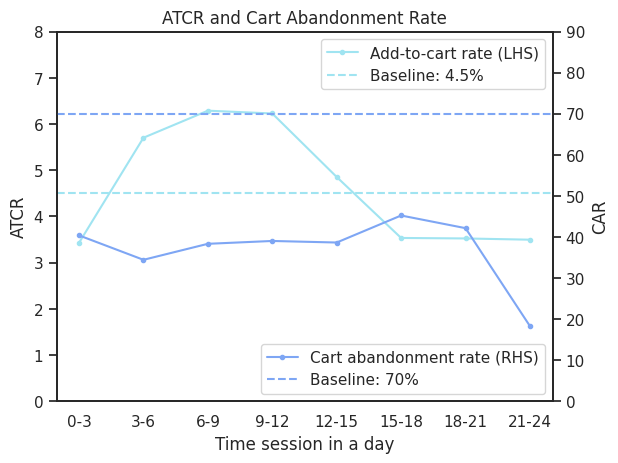

In [36]:
# visualization
fig, ax1 = plt.subplots()

avg_atcr = 4.5
ax1.plot(atcr_by_time_session.index, atcr_by_time_session.atcr, marker='.', color='#A0E4F1', label='Add-to-cart rate (LHS)')
ax1.axhline(y=avg_atcr, linestyle='--', color='#A0E4F1', linewidth=1.5, label=f'Baseline: {avg_atcr}%')
ax1.set_ylim([0, 8])
ax1.set_xlabel("Time session in a day")
ax1.set_ylabel("ATCR")
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
ax2.plot(ctcr_by_time_session.index, ctcr_by_time_session.car, marker='.', color='#7EA6F4', label='Cart abandonment rate (RHS)')
ax2.axhline(y=70, linestyle='--', color='#7EA6F4', linewidth=1.5, label='Baseline: 70%')
ax2.set_ylim([0, 90])
ax2.set_ylabel("CAR")
ax2.legend(loc="lower right")

plt.title("ATCR and Cart Abandonment Rate")
plt.xticks(time_sessions, session_labels)


### Time interval between each decision to act

In [37]:
# filter out records with all three events
data_test_new = data_oct_smrtph.iloc[:120000].astype(
    {
    'product_id': 'str', 
    'category_id': 'str',
    'user_id': 'str'
    })

len_pid = data_test_new.product_id.str.len().max()
len_cid = data_test_new.category_id.str.len().max()
len_uid = data_test_new.user_id.str.len().max()
data_test_new['product_id'] = data_test_new.product_id.apply(lambda x: x.zfill(len_pid))
data_test_new['category_id'] = data_test_new.category_id.apply(lambda x: x.zfill(len_cid))
data_test_new['user_id'] = data_test_new.user_id.apply(lambda x: x.zfill(len_uid))

data_test_new["uid"] = data_test_new.user_id + data_test_new.brand + data_test_new.product_id
uid_view = data_test_new[data_test_new.event_type == 'view'].uid.unique()
uid_cart = data_test_new[data_test_new.event_type == 'cart'].uid.unique()
uid_purchase = data_test_new[data_test_new.event_type == 'purchase'].uid.unique()

uid_common = list(set(uid_view) & set(uid_cart) & set(uid_purchase))
len(uid_common)

1970

1.	Filter userid+productid+brand with all three events (view-cart-purchase, with purchase being the end)
2.	Calculate number of sessions between first view to end purchase. What’s the average user session numbers before a customer place an order?
3.	Calculate the time gap between decisions:
a)	First view – ATC
b)	ATC – purchase
What’s the average time interval between each decision? May use box plot
4.	Calculate the price change from first view, ATC and final payment. Is there any price changes that possibly affect consumer’s decision to buy?
5.	Brand analysis (simply)


In [38]:
data_filtered = data_test_new[data_test_new.uid.isin(uid_common)]
data_filtered.shape

(11574, 10)

In [39]:
# analyze time interval between decisions
def dt64_to_dt(datetime64):
    return datetime.utcfromtimestamp(datetime64.tolist()/1e9)

header = [
            'uid',
            'time_view_to_cart',
            'cart_duration',
            'time_cart_to_purchase',
            'time_view_to_purchase',
            'num_user_sessions',
            'price_change_view_to_cart',
            'price_change_cart_to_purchase'
            ]
interval_df = pd.DataFrame(columns=header)

for i in uid_common:
    data_selected = data_filtered[data_filtered.uid == i].sort_values(by="event_time").reset_index(drop=True)
    purchase_index = data_selected[data_selected.event_type == 'purchase'].index[-1]
    data_selected = data_selected.loc[:purchase_index, :]
    
    # time gap
    try:
        time_view = dt64_to_dt(data_selected[data_selected.event_type == 'view'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_view = np.nan

    try:
        time_cart_first = dt64_to_dt(data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_cart_first = np.nan
    
    try:
        time_cart_final = dt64_to_dt(data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='last')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_cart_final = np.nan
    
    try:
        time_purchase = dt64_to_dt(data_selected[data_selected.event_type == 'purchase'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_purchase = np.nan 


    try:
        cart_duration = timedelta.Timedelta(time_cart_final - time_cart_first).total.seconds
    except (AttributeError, TypeError):
        cart_duration = np.nan
    
    try:
        view_to_cart = timedelta.Timedelta(time_cart_first - time_view).total.seconds
    except (AttributeError, TypeError):
        view_to_cart = np.nan
    
    try:
        cart_to_purchase = timedelta.Timedelta(time_purchase - time_cart_final).total.seconds
    except (AttributeError, TypeError):
        cart_to_purchase = np.nan
    
    try:
        view_to_purchase = timedelta.Timedelta(time_purchase - time_view).total.seconds
    except (AttributeError, TypeError):
        view_to_purchase = np.nan

    # user session gap
    user_session_gap = data_selected.user_session.nunique()

    # price change
    try:
        price_view = data_selected[data_selected.event_type == 'view'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_view = np.nan
    
    try:
        price_cart = data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_cart = np.nan
    
    try:
        price_purchase = data_selected[data_selected.event_type == 'purchase'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_purchase = np.nan

    price_change_view_to_cart = price_cart / price_view - 1
    price_change_cart_to_purchase = price_purchase / price_cart - 1

    # combine and append
    record = [
                i, 
                view_to_cart, 
                cart_duration, 
                cart_to_purchase, 
                view_to_purchase,
                user_session_gap,
                price_change_view_to_cart,
                price_change_cart_to_purchase
                ]
    
    interval_df.loc[interval_df.shape[0]] = record

interval_df.head(10)


,uid,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
0,532237822samsung1004856,43.0,0.0,92.0,135.0,1,0.000000,0.0
1,551031307samsung1004767,7868.0,0.0,149.0,8017.0,2,-0.001963,0.0
2,542036785samsung1004833,61.0,0.0,72.0,133.0,1,0.000000,0.0
3,524095079apple1004249,11.0,0.0,11.0,22.0,1,0.000000,0.0
4,554444304samsung1004870,58.0,0.0,56.0,114.0,1,0.000000,0.0
5,513334519apple1004240,12.0,0.0,21.0,33.0,1,0.000000,0.0
6,540064374samsung1004856,86.0,0.0,425.0,511.0,1,0.000000,0.0
7,514474752apple1005115,14.0,57.0,15.0,86.0,1,0.000000,0.0
8,555550108samsung1004767,127.0,11.0,241.0,379.0,1,0.000000,0.0
9,555482131samsung1004833,586.0,9.0,133.0,728.0,2,0.000000,0.0


In [40]:
interval_df = interval_df.reset_index()
interval_df.set_index('uid', inplace=True)
interval_df = interval_df.astype(float).dropna(how='any')
interval_df.describe()

,index,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
count,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000
mean,985.445125,422.042879,338.157734,-141.871363,618.329250,1.222052,-0.000049,0.000002
std,569.191727,1823.986004,1758.662552,1621.122812,2017.066221,0.610768,0.001119,0.000245
min,0.000000,-15.000000,0.000000,-21874.000000,-2681.000000,1.000000,-0.034630,-0.001963
25%,491.500000,16.000000,0.000000,21.500000,64.000000,1.000000,0.000000,0.000000
50%,987.000000,34.000000,0.000000,59.000000,136.000000,1.000000,0.000000,0.000000
75%,1477.500000,97.000000,26.000000,114.000000,288.000000,1.000000,0.000000,0.000000
max,1969.000000,20334.000000,21890.000000,6550.000000,20583.000000,10.000000,0.000980,0.009546


In [41]:
interval_df_new = interval_df.copy()

cols_to_winsor = ['time_view_to_cart', 'cart_duration', 'time_cart_to_purchase', 'time_view_to_purchase']
time_bound = [300, 120, 300, 900]
for i in range(len(cols_to_winsor)):
    # interval_df_new[col] = mstats.winsorize(interval_df_new[col], limits=[0, 0.15])
    col = cols_to_winsor[i]
    timelim = time_bound[i]
    interval_df_new.loc[interval_df_new[col] > timelim, col] = timelim
    interval_df_new.loc[interval_df_new[col] < 0, col] = 0
interval_df_new.describe()

,index,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
count,1959.000000,1959.00000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000
mean,985.445125,80.77999,24.509444,81.082185,245.322614,1.222052,-0.000049,0.000002
std,569.191727,97.69997,43.586374,77.610693,267.970784,0.610768,0.001119,0.000245
min,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,-0.034630,-0.001963
25%,491.500000,16.00000,0.000000,21.500000,64.000000,1.000000,0.000000,0.000000
50%,987.000000,34.00000,0.000000,59.000000,136.000000,1.000000,0.000000,0.000000
75%,1477.500000,97.00000,26.000000,114.000000,288.000000,1.000000,0.000000,0.000000
max,1969.000000,300.00000,120.000000,300.000000,900.000000,10.000000,0.000980,0.009546


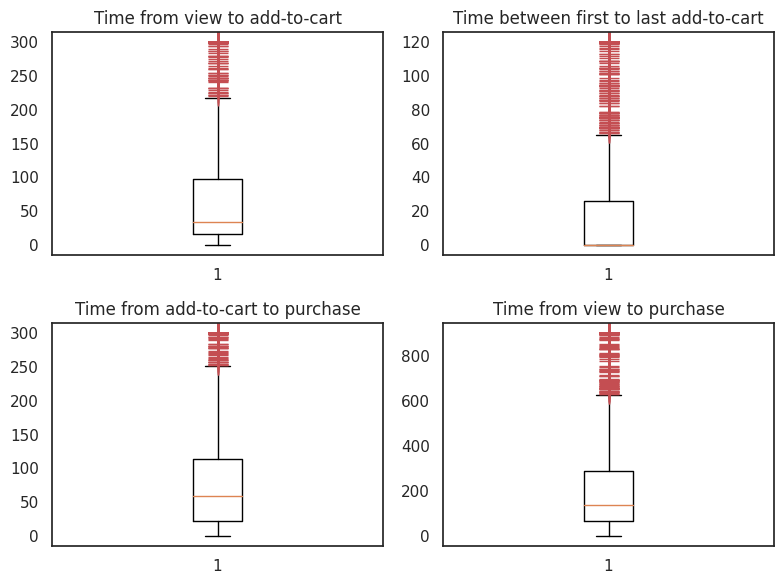

In [42]:

flierprops = dict(marker='+', markerfacecolor='g', markersize=15, linestyle='none', markeredgecolor='r')
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(221)
ax1.boxplot(interval_df_new.time_view_to_cart, flierprops=flierprops)
ax1.set_title('Time from view to add-to-cart')


ax2 = fig.add_subplot(222)
ax2.boxplot(interval_df_new.cart_duration, flierprops=flierprops)
ax2.set_title('Time between first to last add-to-cart')


ax3 = fig.add_subplot(223)
ax3.boxplot(interval_df_new.time_cart_to_purchase, flierprops=flierprops)
ax3.set_title('Time from add-to-cart to purchase')


ax4 = fig.add_subplot(224)
ax4.boxplot(interval_df_new.time_view_to_purchase, flierprops=flierprops)
ax4.set_title('Time from view to purchase')


fig.tight_layout()